#Assignment 3:Deep Neural Networks for Collaborative Filtering techniques


In [1]:
# prompt: unzip file

!unzip ratings.dat.zip


Archive:  ratings.dat.zip
  inflating: ratings.dat             


#Importing Libraries

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

#Loading The Data

In [14]:
# Load the data
def load_data(file_path):
    # Read the data
    df = pd.read_csv(file_path, sep='::', header=None, engine='python',
                     names=['user_id', 'item_id', 'rating', 'timestamp'])

    # Map user and item IDs to continuous indices
    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()

    user_id_map = {old: new for new, old in enumerate(user_ids)}
    item_id_map = {old: new for new, old in enumerate(item_ids)}

    df['user_idx'] = df['user_id'].map(user_id_map)
    df['item_idx'] = df['item_id'].map(item_id_map)

    return df, len(user_ids), len(item_ids)

# Load the data
data_path = 'ratings.dat'  # You'll need to provide this file
df, num_users, num_items = load_data(data_path)

# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

Number of users: 6040
Number of items: 3706
Train samples: 800167
Test samples: 200042


#Data Loaders

In [15]:
# Dataset class
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.LongTensor(df['user_idx'].values)
        self.items = torch.LongTensor(df['item_idx'].values)
        self.ratings = torch.FloatTensor(df['rating'].values)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Create datasets and dataloaders
train_dataset = RatingDataset(train_df)
test_dataset = RatingDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

criterion = nn.MSELoss()

#Training And Evaluation Of NCF

In [16]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=64, hidden_layers=[64, 32, 16]):
        super(NCF, self).__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)

        # MLP layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip([2*embedding_size] + hidden_layers[:-1], hidden_layers):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

    def forward(self, user, item):
        # Get embeddings
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)

        # Concatenate embeddings
        x = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through MLP
        for layer in self.fc_layers:
            x = F.relu(layer(x))

        # Output
        out = torch.sigmoid(self.output(x)) * 4 + 1  # Scale to 1-5 rating range

        return out.squeeze()



# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NCF(num_users, num_items).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (users, items, ratings) in enumerate(train_loader):
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            optimizer.zero_grad()
            predictions = model(users, items)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

# Train and evaluate NCF
print("Training NCF model...")
train(model, train_loader, optimizer, criterion, device, epochs=10)

Training NCF model...
Epoch 1, Loss: 1.0363
Epoch 2, Loss: 0.8580
Epoch 3, Loss: 0.8221
Epoch 4, Loss: 0.8058
Epoch 5, Loss: 0.7956
Epoch 6, Loss: 0.7874
Epoch 7, Loss: 0.7799
Epoch 8, Loss: 0.7729
Epoch 9, Loss: 0.7666
Epoch 10, Loss: 0.7594
Evaluating NCF model...
MSE: 0.8297, MAE: 0.7198


In [20]:
# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            preds = model(users, items)

            predictions.extend(preds.cpu().numpy())
            actuals.extend(ratings.cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')
    return mse, mae


print("Evaluating NCF model...")
ncf_mse, ncf_mae = evaluate(model, test_loader, device)

Evaluating NCF model...
MSE: 0.8326, MAE: 0.7217


#Training And Evaluation Of GNN

In [22]:
# Prepare graph data
def create_graph_data(df, num_users, num_items):
    # Create user-item bipartite graph
    user_nodes = df['user_idx'].values
    item_nodes = df['item_idx'].values + num_users  # Offset items to avoid ID collision

    # Create edges (user->item and item->user)
    edge_index = torch.tensor([
        np.concatenate([user_nodes, item_nodes]),  # Source nodes
        np.concatenate([item_nodes, user_nodes])    # Target nodes
    ], dtype=torch.long)

    # Edge weights (ratings normalized to 0-1)
    edge_weights = torch.tensor(np.concatenate([
        df['rating'].values / 5.0,
        df['rating'].values / 5.0
    ]), dtype=torch.float)

    return Data(x=None, edge_index=edge_index, edge_attr=edge_weights)

graph_data = create_graph_data(train_df, num_users, num_items)

# GNN Model
class GNNCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=64, num_layers=3):
        super(GNNCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.num_layers = num_layers

        # Initial embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)

        # GNN layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(embedding_size, embedding_size, add_self_loops=False))

        # Initialize weights
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)

    def forward(self, user, item, edge_index, edge_weight):
        # Create all embeddings
        user_embeds = self.user_embedding(torch.arange(0, self.num_users, device=user.device))
        item_embeds = self.item_embedding(torch.arange(0, self.num_items, device=item.device))
        x = torch.cat([user_embeds, item_embeds], dim=0)

        # Message passing
        embeddings = [x]
        for conv in self.convs:
            x = F.leaky_relu(conv(x, edge_index, edge_weight=edge_weight))
            embeddings.append(x)

        # Combine all layer embeddings
        final_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)

        # Split back into users and items
        user_final, item_final = final_embedding[:self.num_users], final_embedding[self.num_users:]

        # Get embeddings for input users and items
        user_embedded = user_final[user]
        item_embedded = item_final[item]

        # Dot product
        out = (user_embedded * item_embedded).sum(dim=1)

        # Scale to rating range
        out = torch.sigmoid(out) * 4 + 1

        return out

    def get_embeddings(self, edge_index, edge_weight):
        # Create all embeddings
        user_embeds = self.user_embedding(torch.arange(0, self.num_users).to(edge_index.device))
        item_embeds = self.item_embedding(torch.arange(0, self.num_items).to(edge_index.device))
        x = torch.cat([user_embeds, item_embeds], dim=0)

        # Message passing
        embeddings = [x]
        for conv in self.convs:
            x = F.leaky_relu(conv(x, edge_index, edge_weight=edge_weight))
            embeddings.append(x)

        # Combine all layer embeddings
        final_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)

        # Split back into users and items
        user_final, item_final = final_embedding[:self.num_users], final_embedding[self.num_users:]

        return user_final, item_final

# Initialize GNN model
gnn_model = GNNCF(num_users, num_items).to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Prepare graph data for PyTorch Geometric
graph_data = graph_data.to(device)

# Training function for GNN
def train_gnn(model, train_loader, optimizer, criterion, graph_data, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (users, items, ratings) in enumerate(train_loader):
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            optimizer.zero_grad()
            predictions = model(users, items, graph_data.edge_index, graph_data.edge_attr)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

# Train and evaluate GNN
print("Training GNN model...")
train_gnn(gnn_model, train_loader, gnn_optimizer, criterion, graph_data, device, epochs=10)


Training GNN model...
Epoch 1, Loss: 0.9518
Epoch 2, Loss: 0.8333
Epoch 3, Loss: 0.8022
Epoch 4, Loss: 0.7786
Epoch 5, Loss: 0.7626
Epoch 6, Loss: 0.7498
Epoch 7, Loss: 0.7390
Epoch 8, Loss: 0.7283
Epoch 9, Loss: 0.7173
Epoch 10, Loss: 0.7075


In [28]:
def evaluate(model, test_loader, device, graph_data=None):
    """Evaluates the model and returns MSE and MAE.

    Args:
        model: The model to evaluate.
        test_loader: The data loader for the test set.
        device: The device to use for computation.
        graph_data: The graph data for GNN models.

    Returns:
        A tuple containing the MSE and MAE.
    """
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)

            # Check if the model is a GNN model and pass graph data if necessary
            if isinstance(model, GNNCF):
                preds = model(users, items, graph_data.edge_index, graph_data.edge_attr)  # Pass graph_data here
            else:
                preds = model(users, items)

            predictions.extend(preds.cpu().numpy())
            actuals.extend(ratings.cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')
    return mse, mae

print("Evaluating GNN model...")
gnn_mse, gnn_mae = evaluate(gnn_model, test_loader, device, graph_data=graph_data) # Pass graph_data to evaluate function

Evaluating GNN model...
MSE: 0.7526, MAE: 0.6845


#Results

In [31]:
# Compare results
results = {
    'Model': ['Neural Collaborative Filtering', 'Graph Neural Network'],
    'MSE': [ncf_mse, gnn_mse],
    'MAE': [ncf_mae, gnn_mae]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                            Model       MSE       MAE
0  Neural Collaborative Filtering  0.832628  0.721678
1            Graph Neural Network  0.752649  0.684515


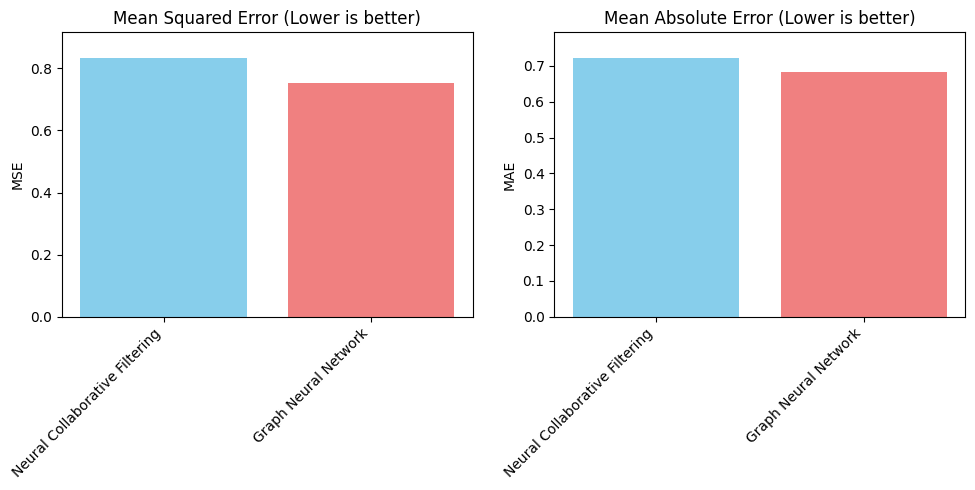

In [30]:
#plot results
plt.figure(figsize=(10, 5))

# MSE plot
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['MSE'], color=['skyblue', 'lightcoral']) # Added colors
plt.title('Mean Squared Error (Lower is better)', fontsize=12) # Increased fontsize
plt.xticks(rotation=45, ha='right') # Rotated and aligned xticks
plt.ylabel("MSE") # Added y-axis label
plt.ylim(0, max(results_df['MSE']) * 1.1)  # Adjust y-axis limit for better visualization

# MAE plot
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['MAE'], color=['skyblue', 'lightcoral']) # Added colors
plt.title('Mean Absolute Error (Lower is better)', fontsize=12) # Increased fontsize
plt.xticks(rotation=45, ha='right') # Rotated and aligned xticks
plt.ylabel("MAE")  # Added y-axis label
plt.ylim(0, max(results_df['MAE']) * 1.1) # Adjust y-axis limit

plt.tight_layout()
plt.show()
